<a href="https://colab.research.google.com/github/adlihs/instatXML/blob/main/Instat_%7C_Pass_Map_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplsoccer
!pip install -U pandasql
!pip install highlight-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 2.5 MB/s 
  Created wheel for mplsoccer: filename=mplsoccer-1.1.3-py3-none-any.whl size=68833 sha256=9ad4c0ce4f3cfe68ed1ce504617f88db47c47303ea5c420f7807bbfb316d4ee6
  Stored in directory: /root/.cache/pip/wheels/1d/db/cd/c447db2c51008636754add273f8ceac0751aab6a9f13166ec4
Successfully built mplsoccer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=1a1f5a11e076ece12024c09a07afed1ca4d6168ee5a23090cb238792597bdd07
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setup pandasql

In [2]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

## Import packages

In [3]:
import os, sys 
#to be able to interact with Google Drive's operating system
from google.colab import drive 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba,LinearSegmentedColormap
from urllib.request import urlopen
from PIL import Image
from mplsoccer import Pitch,VerticalPitch, FontManager, Sbopen, add_image
from highlight_text import ax_text
import matplotlib.patheffects as path_effects

## Load fonts

In [5]:
import matplotlib as mpl
import matplotlib.font_manager as fm

#!mv /content/drive/MyDrive/fonts/Comfortaa-Bold.ttf /usr/share/fonts/truetype/

path = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf' #'/usr/share/fonts/truetype/Oswald-Bold.ttf'
fontprop = fm.FontProperties(fname=path, size= 35)
game_det_fontprop = fm.FontProperties(fname=path, size=20)
title_det_fontprop = fm.FontProperties(fname=path, size=15)


## Load Instat data

In [6]:
%cd '/content/drive/MyDrive/SIFUTCR'

main_df = pd.read_parquet('UNAFUT.parquet')
main_df.query("Acciones != 'Ataques posicionales'",inplace=True) 
main_df.head()

/content/drive/MyDrive/SIFUTCR


,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones,...,nombre_torneo,equipo_casa,equipo_visita,marcador,goles_local,goles_visita,rival,marcador_casa,marcador_visita,detalle_marcador
1,2,4.050781,24.05,52.9,34.2,Guanacasteca-0-2-Herediano2,10,Yeltsin Tejeda,Herediano,Pases precisos,...,Apertura 2022,Guanacasteca,Herediano,0-2,0,2,Guanacasteca,0.0,0.0,0-0
4,5,7.320312,27.32,35.4,39.5,Guanacasteca-0-2-Herediano2,5,Ariel Roman Soto,Herediano,Pases precisos,...,Apertura 2022,Guanacasteca,Herediano,0-2,0,2,Guanacasteca,0.0,0.0,0-0
6,7,8.773438,28.77,61.9,19.0,Guanacasteca-0-2-Herediano2,4,Orlando Moises Galo Calderon,Herediano,Pases precisos,...,Apertura 2022,Guanacasteca,Herediano,0-2,0,2,Guanacasteca,0.0,0.0,0-0
8,9,9.921875,29.92,71.3,13.7,Guanacasteca-0-2-Herediano2,9,Anthony Daniel Contreras Enriquez,Herediano,Pases inefectivo,...,Apertura 2022,Guanacasteca,Herediano,0-2,0,2,Guanacasteca,0.0,0.0,0-0
9,11,21.250000,41.25,61.0,0.0,Guanacasteca-0-2-Herediano2,97,Rawy Jafet Rodriguez Osorio,Herediano,Pases precisos,...,Apertura 2022,Guanacasteca,Herediano,0-2,0,2,Guanacasteca,0.0,0.0,0-0


## Get teams starting lineups by game

In [7]:
#main_df = main_df.query("jugador != ' Aaron Moises Cruz Esquivel' ")
#main_df['jugador'].unique()

In [8]:
def get_lineups(instat_data):
  main_df = instat_data
  '''
  Process to identify the startup lineup by games and teams
  '''
  # Get the minimum ID of player's action
  #query = "SELECT  Partido, Equipos, camisa, jugador, min(ID) as 'min_id' FROM main_df WHERE Partido = '{}' GROUP BY Partido, Equipos, camisa, jugador".format(game)
  query = "SELECT  Partido, Equipos, camisa, jugador, min(ID) as 'min_id' FROM main_df GROUP BY Partido, Equipos, camisa, jugador"
  lineup_df = pysqldf(query) 
  lineup_df['min_id'] = pd.to_numeric(lineup_df['min_id'])
  
  #Get the list of games
  partidos = lineup_df['Partido'].unique()


  lineups_data = pd.DataFrame()
  for game in partidos:
    temp_df = lineup_df.query("Partido == @game")
    teams_temp_df = temp_df['Equipos'].unique()
    for teams in teams_temp_df:
      temp_df = lineup_df.query("Partido == @game and Equipos == @teams")
      temp_lineup = temp_df.nsmallest(n=11, columns=['min_id'], keep='last')
      lineups_data = lineups_data.append(temp_lineup) 
  return lineups_data

In [9]:
xx = get_lineups(main_df)
xx.query("Partido == 'Deportivo-Saprissa-1-1-Puntarenas2'")

,Partido,Equipos,camisa,jugador,min_id
133,Deportivo-Saprissa-1-1-Puntarenas2,Puntarenas,80,Greivin Mendez Venegas,10
120,Deportivo-Saprissa-1-1-Puntarenas2,Puntarenas,10,Yoserth Hernandez Loria,100
123,Deportivo-Saprissa-1-1-Puntarenas2,Puntarenas,15,Krisler Villalobos Chavarria,104
134,Deportivo-Saprissa-1-1-Puntarenas2,Puntarenas,99,Guido Antonio Jimenez Lopez,1012
128,Deportivo-Saprissa-1-1-Puntarenas2,Puntarenas,25,Kliver Gomez Salas,1018
121,Deportivo-Saprissa-1-1-Puntarenas2,Puntarenas,11,Anthony Hernandez Gonzalez,1028
132,Deportivo-Saprissa-1-1-Puntarenas2,Puntarenas,7,Kevin Alberto Sancho Ramos,1040
130,Deportivo-Saprissa-1-1-Puntarenas2,Puntarenas,4,William Alban Fernandez Gonzalez,1044
124,Deportivo-Saprissa-1-1-Puntarenas2,Puntarenas,16,Jurguens Josafat Montenegro Vallejo,1049
122,Deportivo-Saprissa-1-1-Puntarenas2,Puntarenas,12,Asdrubal Enrique Gibbons Hidalgo,1063


## Filter main dataframe with important columns

In [10]:
pass_df = main_df[['ID','start','end','pos_x','pos_y','Partido','camisa','jugador','Equipos','Acciones']]
pass_df.head()

,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones
1,2,4.050781,24.05,52.9,34.2,Guanacasteca-0-2-Herediano2,10,Yeltsin Tejeda,Herediano,Pases precisos
4,5,7.320312,27.32,35.4,39.5,Guanacasteca-0-2-Herediano2,5,Ariel Roman Soto,Herediano,Pases precisos
6,7,8.773438,28.77,61.9,19.0,Guanacasteca-0-2-Herediano2,4,Orlando Moises Galo Calderon,Herediano,Pases precisos
8,9,9.921875,29.92,71.3,13.7,Guanacasteca-0-2-Herediano2,9,Anthony Daniel Contreras Enriquez,Herediano,Pases inefectivo
9,11,21.250000,41.25,61.0,0.0,Guanacasteca-0-2-Herediano2,97,Rawy Jafet Rodriguez Osorio,Herediano,Pases precisos


## Remove actions with the same (x,y) position as passes and assists

In [11]:
# Identify x,y for passes and assists
duplicate_pass_location = pysqldf("SELECT distinct ID,pos_x, pos_y from pass_df WHERE Acciones in ('Pases precisos','Asistencias')")

duplicates_id = pysqldf("SELECT distinct a.ID,a.pos_x,a.pos_y from pass_df A inner join duplicate_pass_location B ON a.pos_x = b.pos_x and a.pos_y = b.pos_y WHERE A.Acciones not in ('Pases precisos','Asistencias') ")

#pass_df = pysqldf("SELECT * FROM pass_df WHERE ([ID],pos_x,pos_y) NOT IN (SELECT [ID],pos_x,pos_y FROM duplicates_id) ")

pass_df = pysqldf("SELECT A.* FROM pass_df A  LEFT JOIN duplicates_id B ON A.ID = B.ID and A.pos_x = B.pos_x and A.pos_y = B.pos_y WHERE B.ID is null ")
pass_df.head()

,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones
0,2,4.050781,24.05,52.9,34.2,Guanacasteca-0-2-Herediano2,10,Yeltsin Tejeda,Herediano,Pases precisos
1,5,7.320312,27.32,35.4,39.5,Guanacasteca-0-2-Herediano2,5,Ariel Roman Soto,Herediano,Pases precisos
2,7,8.773438,28.77,61.9,19.0,Guanacasteca-0-2-Herediano2,4,Orlando Moises Galo Calderon,Herediano,Pases precisos
3,9,9.921875,29.92,71.3,13.7,Guanacasteca-0-2-Herediano2,9,Anthony Daniel Contreras Enriquez,Herediano,Pases inefectivo
4,11,21.250000,41.25,61.0,0.0,Guanacasteca-0-2-Herediano2,97,Rawy Jafet Rodriguez Osorio,Herediano,Pases precisos


## Setup the `end` columns (x,y,jugadores,equipos,acciones)

In [12]:
pass_df['pos_x_end'] = pass_df['pos_x'].shift(-1)
pass_df['pos_y_end'] = pass_df['pos_y'].shift(-1)
pass_df['jugador_end'] = pass_df['jugador'].shift(-1)
pass_df['camisa_end'] = pass_df['camisa'].shift(-1)
pass_df['equipos_end'] = pass_df['Equipos'].shift(-1)
pass_df['acciones_end'] = pass_df['Acciones'].shift(-1)
pass_df.head()

,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones,pos_x_end,pos_y_end,jugador_end,camisa_end,equipos_end,acciones_end
0,2,4.050781,24.05,52.9,34.2,Guanacasteca-0-2-Herediano2,10,Yeltsin Tejeda,Herediano,Pases precisos,35.4,39.5,Ariel Roman Soto,5,Herediano,Pases precisos
1,5,7.320312,27.32,35.4,39.5,Guanacasteca-0-2-Herediano2,5,Ariel Roman Soto,Herediano,Pases precisos,61.9,19.0,Orlando Moises Galo Calderon,4,Herediano,Pases precisos
2,7,8.773438,28.77,61.9,19.0,Guanacasteca-0-2-Herediano2,4,Orlando Moises Galo Calderon,Herediano,Pases precisos,71.3,13.7,Anthony Daniel Contreras Enriquez,9,Herediano,Pases inefectivo
3,9,9.921875,29.92,71.3,13.7,Guanacasteca-0-2-Herediano2,9,Anthony Daniel Contreras Enriquez,Herediano,Pases inefectivo,61.0,0.0,Rawy Jafet Rodriguez Osorio,97,Herediano,Pases precisos
4,11,21.250000,41.25,61.0,0.0,Guanacasteca-0-2-Herediano2,97,Rawy Jafet Rodriguez Osorio,Herediano,Pases precisos,40.0,11.7,Juan Miguel Basulto Medina,24,Herediano,Pases precisos


## Select only passes and assists

In [13]:
onlyPasses = pass_df.query("Acciones in ('Pases precisos','Asistencias')") 
onlyPasses.head(5)

,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones,pos_x_end,pos_y_end,jugador_end,camisa_end,equipos_end,acciones_end
0,2,4.050781,24.05,52.9,34.2,Guanacasteca-0-2-Herediano2,10,Yeltsin Tejeda,Herediano,Pases precisos,35.4,39.5,Ariel Roman Soto,5,Herediano,Pases precisos
1,5,7.320312,27.32,35.4,39.5,Guanacasteca-0-2-Herediano2,5,Ariel Roman Soto,Herediano,Pases precisos,61.9,19.0,Orlando Moises Galo Calderon,4,Herediano,Pases precisos
2,7,8.773438,28.77,61.9,19.0,Guanacasteca-0-2-Herediano2,4,Orlando Moises Galo Calderon,Herediano,Pases precisos,71.3,13.7,Anthony Daniel Contreras Enriquez,9,Herediano,Pases inefectivo
4,11,21.250000,41.25,61.0,0.0,Guanacasteca-0-2-Herediano2,97,Rawy Jafet Rodriguez Osorio,Herediano,Pases precisos,40.0,11.7,Juan Miguel Basulto Medina,24,Herediano,Pases precisos
5,14,25.187500,45.18,40.0,11.7,Guanacasteca-0-2-Herediano2,24,Juan Miguel Basulto Medina,Herediano,Pases precisos,33.9,33.2,Ariel Roman Soto,5,Herediano,Pases precisos


## Select passes where `Equipos` is equal to `equipos_end`.
With this filter we ensure that the player makes a pass to a team player

In [42]:
pass_flow_df = onlyPasses
onlyPasses.query("Equipos == equipos_end", inplace=True)
onlyPasses.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones,pos_x_end,pos_y_end,jugador_end,camisa_end,equipos_end,acciones_end
0,2,4.050781,24.05,52.9,34.2,Guanacasteca-0-2-Herediano2,10,Yeltsin Tejeda,Herediano,Pases precisos,35.4,39.5,Ariel Roman Soto,5,Herediano,Pases precisos
1,5,7.320312,27.32,35.4,39.5,Guanacasteca-0-2-Herediano2,5,Ariel Roman Soto,Herediano,Pases precisos,61.9,19.0,Orlando Moises Galo Calderon,4,Herediano,Pases precisos
2,7,8.773438,28.77,61.9,19.0,Guanacasteca-0-2-Herediano2,4,Orlando Moises Galo Calderon,Herediano,Pases precisos,71.3,13.7,Anthony Daniel Contreras Enriquez,9,Herediano,Pases inefectivo
4,11,21.250000,41.25,61.0,0.0,Guanacasteca-0-2-Herediano2,97,Rawy Jafet Rodriguez Osorio,Herediano,Pases precisos,40.0,11.7,Juan Miguel Basulto Medina,24,Herediano,Pases precisos
5,14,25.187500,45.18,40.0,11.7,Guanacasteca-0-2-Herediano2,24,Juan Miguel Basulto Medina,Herediano,Pases precisos,33.9,33.2,Ariel Roman Soto,5,Herediano,Pases precisos


## Count passes between players by games

In [15]:
pass_count_players = pysqldf("SELECT Partido, Equipos, jugador, camisa, equipos_end, jugador_end,camisa_end,count(*) 'cantidad_pases' from onlyPasses group by Partido,Equipos, jugador, camisa, equipos_end,jugador_end,camisa_end")
pass_count_players.head()

,Partido,Equipos,jugador,camisa,equipos_end,jugador_end,camisa_end,cantidad_pases
0,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Aaron Rene Suarez Zuniga,25,Alajuelense,Alex Lopez Rodrigues,11,7
1,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Aaron Rene Suarez Zuniga,25,Alajuelense,Alexis Yohaslin Gamboa Rojas,13,1
2,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Aaron Rene Suarez Zuniga,25,Alajuelense,Bryan Felix,29,1
3,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Aaron Rene Suarez Zuniga,25,Alajuelense,Bryan Ruiz,10,5
4,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Aaron Rene Suarez Zuniga,25,Alajuelense,Carlos Andrei Mora Montoya,17,6


## Average Position players by Games

In [16]:
players_avg_position = pysqldf("SELECT Partido,Equipos,jugador, camisa, avg(pos_x) as 'avg_pos_x', avg(pos_y) as 'avg_pos_y' FROM main_df WHERE Acciones in ('Pases precisos','Asistencias') GROUP BY Partido,Equipos,jugador, camisa ")
players_avg_position.head()



,Partido,Equipos,jugador,camisa,avg_pos_x,avg_pos_y
0,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Aaron Rene Suarez Zuniga,25,66.318000,27.452000
1,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Alex Lopez Rodrigues,11,53.926471,39.894118
2,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Alexis Yohaslin Gamboa Rojas,13,39.612500,47.980357
3,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Bernald Alfaro Alfaro,26,82.566667,46.333333
4,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Bryan Felix,29,88.080000,62.340000


In [17]:
start11 = get_lineups(main_df)

#Only 11 startup
players_avg_position = pd.merge(players_avg_position, start11, on=["Partido","Equipos","jugador","camisa"])

## Add avg position columns to `pass_count_players` dataframe

In [18]:
# Average position columns for 'jugador'
pass_count_players = pysqldf("SELECT A.*, B.avg_pos_x as 'jugador_avg_pos_x', B.avg_pos_y as 'jugador_avg_pos_y' FROM pass_count_players A LEFT JOIN players_avg_position B on A.Partido = B.Partido and A.jugador = B.jugador and A.camisa = B.camisa and A.Equipos = B.Equipos")
# Average position columns for 'jugador_end'
pass_count_players = pysqldf("SELECT A.*, B.avg_pos_x as 'jugador_end_avg_pos_x', B.avg_pos_y as 'jugador_end_avg_pos_y' FROM pass_count_players A LEFT JOIN players_avg_position B on A.Partido = B.Partido and A.jugador_end = B.jugador and A.camisa_end = B.camisa and A.Equipos = B.Equipos")

pass_count_players.head()

,Partido,Equipos,jugador,camisa,equipos_end,jugador_end,camisa_end,cantidad_pases,jugador_avg_pos_x,jugador_avg_pos_y,jugador_end_avg_pos_x,jugador_end_avg_pos_y
0,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Aaron Rene Suarez Zuniga,25,Alajuelense,Alex Lopez Rodrigues,11,7,66.318,27.452,53.926471,39.894118
1,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Aaron Rene Suarez Zuniga,25,Alajuelense,Alexis Yohaslin Gamboa Rojas,13,1,66.318,27.452,39.612500,47.980357
2,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Aaron Rene Suarez Zuniga,25,Alajuelense,Bryan Felix,29,1,66.318,27.452,NaN,NaN
3,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Aaron Rene Suarez Zuniga,25,Alajuelense,Bryan Ruiz,10,5,66.318,27.452,58.745833,43.675000
4,Alajuelense-2-0-Santos-de-Guapile,Alajuelense,Aaron Rene Suarez Zuniga,25,Alajuelense,Carlos Andrei Mora Montoya,17,6,66.318,27.452,70.944444,17.266667


## Logo function

In [19]:
def set_logos(homeTeam,awayTeam):

  # Home team logo
  if homeTeam == 'Perez Zeledon':
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Perez.png")
    
  elif homeTeam == 'Mun. Grecia': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Grecia.png")
    
  elif homeTeam == 'Guadalupe': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Guadalupe.png")
    
  elif homeTeam == 'Cartagines': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Cartago.png")
    
  elif homeTeam == 'Alajuelense': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/lda.png")
    
  elif homeTeam == 'Herediano': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Heredia.png")
    
  elif homeTeam == 'San Carlos': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/San Carlos.png")
    
  elif homeTeam == 'Saprissa': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Saprissa.png")
    
  elif homeTeam == 'Sporting FC': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Sporting.png")
    
  elif homeTeam == 'Santos': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Santos.png")
    
  elif homeTeam == 'Guanacasteca': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/guana.png")
    
  elif homeTeam == 'Puntarenas': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Puntarenas.png")
                     

  # Away team logo
  if awayTeam == 'Perez Zeledon':
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Perez.png")
    
  elif awayTeam == 'Mun. Grecia': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Grecia.png")
    
  elif awayTeam == 'Guadalupe': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Guadalupe.png")
    
  elif awayTeam == 'Cartagines': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Cartago.png")
    
  elif awayTeam == 'Alajuelense': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/lda.png")
    
  elif awayTeam == 'Herediano': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Heredia.png")
    
  elif awayTeam == 'San Carlos': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/San Carlos.png")
    
  elif awayTeam == 'Saprissa': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Saprissa.png")
  
  elif awayTeam == 'Sporting FC': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Sporting.png")
    
  elif awayTeam == 'Santos': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Santos.png")
    
  elif awayTeam == 'Guanacasteca': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/guana.png")
    
  elif awayTeam == 'Puntarenas': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Puntarenas.png")
  
  
  return image_home,image_away                      

In [20]:
main_df.Equipos.unique()

array(['Herediano', 'Guanacasteca', 'Alajuelense', 'Santos', 'Saprissa',
       'Perez Zeledon', 'San Carlos', 'Puntarenas', 'Mun. Grecia',
       'Cartagines', 'Guadalupe', 'Sporting FC'], dtype=object)

## `Big Table - Players`

### Function

In [21]:
def bigTablePlayers(team=None,player=None,metric=None):
  big_table_players = pysqldf("SELECT Equipos,rtrim(ltrim(jugador)) as 'jugador',Acciones, count(Acciones) as total FROM main_df  group by Equipos,jugador, nombre_torneo, Acciones") 
  big_table_players = big_table_players.pivot(index=['Equipos','jugador'],
                                              columns='Acciones',
                                              values='total')
  big_table_players = big_table_players.reset_index()
  big_table_players = big_table_players.fillna(0)
  big_table_players['total_centros'] = big_table_players['Centros efectivo'] + big_table_players['Centros inefectivo']
  big_table_players['efectividad_centros'] = big_table_players['Centros efectivo'] / big_table_players['total_centros']
  big_table_players['total_disputas_aereas'] = big_table_players['Disputas por arriba perdio'] + big_table_players['Disputas por arriba vencio']
  big_table_players['efectividad_disputas_aereas'] = big_table_players['Disputas por arriba vencio'] / big_table_players['total_disputas_aereas']
  big_table_players['total_disputas'] = big_table_players['Disputas perdio'] + big_table_players['Disputas vencio']
  big_table_players['efectividad_disputas'] = big_table_players['Disputas vencio'] / big_table_players['total_disputas']
  big_table_players['total_entradas'] = big_table_players['Entradas Acciones con exito'] + big_table_players['Entradas Acciones sin  exito']
  big_table_players['efectividad_entradas'] = big_table_players['Entradas Acciones con exito'] / big_table_players['total_entradas']
  big_table_players['total_pases_finalizacion'] = big_table_players['Pases de finalizacion efectivo'] + big_table_players['Pases de finalizacion inefectivo']
  big_table_players['efectividad_pases_finalizacion'] = big_table_players['Pases de finalizacion efectivo'] / big_table_players['total_pases_finalizacion']
  big_table_players['total_regates'] = big_table_players['Regates Acciones con exito'] + big_table_players['Regates Acciones sin  exito']
  big_table_players['efectividad_regates'] = big_table_players['Regates Acciones con exito'] / big_table_players['total_regates']
  big_table_players['total_pases'] = big_table_players['Pases precisos'] + big_table_players['Pases inefectivo'] + big_table_players['Asistencias']
  big_table_players['efectividad_pases'] = (big_table_players['Pases precisos'] +  big_table_players['Asistencias']) / big_table_players['total_pases']

  big_table_players['total_tiros'] = big_table_players['Tiros'] + big_table_players['Goles']
  big_table_players = big_table_players.fillna(0)


  if (team is not None and player is not None and metric is None):
    big_table_players = big_table_players.query("Equipos == @team and jugador == @player")
  elif (team is not None and player is not None and metric is not None):
    metric.insert(0,'Equipos')
    metric.insert(1,'jugador')
    big_table_players = big_table_players[metric]
    big_table_players = big_table_players.query("Equipos == @team and jugador == @player")
  elif (team is not None and player is None and metric is None):
    big_table_players = big_table_players.query("Equipos == @team")
  elif (team is None and player is not None and metric is None):
    big_table_players = big_table_players.query("jugador == @player")
  elif (team is None and player is None and metric is not None):
    metric.insert(0,'Equipos')
    metric.insert(1,'jugador')
    big_table_players = big_table_players[metric]
    

  return big_table_players

### Example

In [22]:
bigTablePlayers(team='Alajuelense', player='Aaron Rene Suarez Zuniga',metric=['Asistencias','Centros efectivo','Faltas','efectividad_pases','total_pases'])


Acciones,Equipos,jugador,Asistencias,Centros efectivo,Faltas,efectividad_pases,total_pases
0,Alajuelense,Aaron Rene Suarez Zuniga,0.0,3.0,5.0,0.825397,126.0


## `Big Table - Teams`

### Function

In [23]:
def bigTableTeams(team=None,metric=None):
  big_table_teams = pysqldf("SELECT Equipos,Acciones, count(Acciones) as total FROM main_df  group by Equipos, nombre_torneo, Acciones") 
  big_table_teams = big_table_teams.pivot(index=['Equipos'],
                                              columns='Acciones',
                                              values='total')
  big_table_teams = big_table_teams.reset_index()
  big_table_teams = big_table_teams.fillna(0)
  big_table_teams['total_centros'] = big_table_teams['Centros efectivo'] + big_table_teams['Centros inefectivo']
  big_table_teams['efectividad_centros'] = big_table_teams['Centros efectivo'] / big_table_teams['total_centros']
  big_table_teams['total_disputas_aereas'] = big_table_teams['Disputas por arriba perdio'] + big_table_teams['Disputas por arriba vencio']
  big_table_teams['efectividad_disputas_aereas'] = big_table_teams['Disputas por arriba vencio'] / big_table_teams['total_disputas_aereas']
  big_table_teams['total_disputas'] = big_table_teams['Disputas perdio'] + big_table_teams['Disputas vencio']
  big_table_teams['efectividad_disputas'] = big_table_teams['Disputas vencio'] / big_table_teams['total_disputas']
  big_table_teams['total_entradas'] = big_table_teams['Entradas Acciones con exito'] + big_table_teams['Entradas Acciones sin  exito']
  big_table_teams['efectividad_entradas'] = big_table_teams['Entradas Acciones con exito'] / big_table_teams['total_entradas']
  big_table_teams['total_pases_finalizacion'] = big_table_teams['Pases de finalizacion efectivo'] + big_table_teams['Pases de finalizacion inefectivo']
  big_table_teams['efectividad_pases_finalizacion'] = big_table_teams['Pases de finalizacion efectivo'] / big_table_teams['total_pases_finalizacion']
  big_table_teams['total_regates'] = big_table_teams['Regates Acciones con exito'] + big_table_teams['Regates Acciones sin  exito']
  big_table_teams['efectividad_regates'] = big_table_teams['Regates Acciones con exito'] / big_table_teams['total_regates']
  big_table_teams['total_pases'] = big_table_teams['Pases precisos'] + big_table_teams['Pases inefectivo'] + big_table_teams['Asistencias']
  big_table_teams['efectividad_pases'] = (big_table_teams['Pases precisos'] +  big_table_teams['Asistencias']) / big_table_teams['total_pases']

  big_table_teams['total_tiros'] = big_table_teams['Tiros'] + big_table_teams['Goles']
  big_table_teams = big_table_teams.fillna(0)


  if (team is not None and metric is None):
    big_table_teams = big_table_teams.query("Equipos == @team")
  elif (team is not None and metric is not None):
    metric.insert(0,'Equipos')
    big_table_teams = big_table_teams[metric]
    big_table_teams = big_table_teams.query("Equipos == @team")
  elif (team is None and metric is not None):
    metric.insert(0,'Equipos')
    big_table_teams = big_table_teams[metric]
    

  return big_table_teams

### Example

In [24]:
bigTableTeams(team='Alajuelense',metric=['total_pases','efectividad_pases'])

Acciones,Equipos,total_pases,efectividad_pases
0,Alajuelense,1565.0,0.860064


## `Pass network`

### Function

In [25]:
def pass_maps(game,team1,team2):
  import re
  import warnings
  warnings.simplefilter("ignore", UserWarning)

  # Variables
  game = game
  team1 = team1
  team2 = team2

  game_details = main_df.query("Partido == @game")

  game_date = game_details['fecha_partido'].unique()
  home_team = game_details['equipo_casa'].unique()
  away_team = game_details['equipo_visita'].unique()
  final_result = game_details['marcador'].unique()
  tournament = game_details['nombre_torneo'].unique()

  # Clean variable strings
  game_date = str(game_date).replace('[', '').replace(']', '').replace("'",'')
  home_team = str(home_team).replace('[', '').replace(']', '').replace("'",'')
  away_team = str(away_team).replace('[', '').replace(']', '').replace("'",'')
  final_result = str(final_result).replace('[', '').replace(']', '').replace("'",'')
  tournament = str(tournament).replace('[', '').replace(']', '').replace("'",'')


  
  
  # Main graph
  pitch = VerticalPitch(pitch_type='custom',
                pitch_length=105,
                pitch_width=68,
                pitch_color='#eee9e5', 
                line_color='#01161E')
  fig, axs = pitch.grid(figheight=14 ,ncols=2, axis=False, endnote_height=0.05,title_height=0.08,)
  fig.set_facecolor("#eee9e5")
  for idx, ax in enumerate(axs['pitch'].flat):
    if idx == 0:
      ######### TEAM 1 PASS MAP #########
      ax1 = ax
      # Filter data for one game, and one team
      pass_count_players_test = pass_count_players.query("Partido == @game and Equipos == @team1 ")

      # Line colors
      MIN_TRANSPARENCY = 0.3
      color = np.array(to_rgba('#6d6a69'))
      color = np.tile(color, (len(pass_count_players_test), 1))
      c_transparency = pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max()
      c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
      color[:, 3] = c_transparency


      # Calculate Line Width
      pass_count_players_test['width']= (pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max() *
                                18)

      # Name and shirt number
      pass_count_players_test['full_name'] = pass_count_players_test.camisa + '.' + pass_count_players_test.jugador
      pass_lines = pitch.lines(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                              pass_count_players_test['jugador_end_avg_pos_x'], pass_count_players_test['jugador_end_avg_pos_y'],
                              lw=pass_count_players_test.width,
                              color=color, zorder=1, ax=ax1)
      pass_nodes = pitch.scatter(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                              s=1000, color='#eee9e5', edgecolors='#6d6a69', linewidth=1, alpha=1, ax=ax1)
      # Put player number in markers
      for index, row in pass_count_players_test.iterrows():
        pitch.annotate(row.camisa, xy=(row.jugador_avg_pos_x, row.jugador_avg_pos_y), c='#6d6a69', va='center',ha='center', size=11, ax=ax1)

      ######### TITLE SECTION #########
      #ss = pass_count_players.query("Partido == @game")
      
      #team1 = pass_count_players_test['Equipos'].unique()
      ax1.text(34, 110, team1, 
              size=35,
              fontproperties = fontprop,
              #fontname = 'Oswald',
              fontweight = 'bold',
              ha='center', va='center', color='#6d6a69')


      #################################

      # List of players
      
      players = pass_count_players_test[['full_name','camisa','jugador_avg_pos_x']]
      players = players.dropna()
      players = players.sort_values(by=['camisa'],ascending=True)
      players = players['full_name'].unique()
      players_name = str(players)
      players_name = players_name.replace('[',' ')
      players_name = players_name.replace(']',' ')
      players_name = players_name.replace("'",' ')
      
      #query = "SELECT DISTINCT full_name FROM pass_count_players_test where jugador_avg_pos_x <> 'Nan' ORDER BY 1 asc"
      #players_name =  pysqldf(query) 

      axs['endnote'].text(0, 0.5, players_name,
                      fontsize=12, va='center', ha='left', color='black')
      axs['endnote'].text(0, 1.5, 'Lineup',
                      fontsize=12, va='center', ha='left', color='black',fontweight = 'bold') 
    else:
      ######### TEAM 2 PASS MAP #########
      ax2 = ax

      # Filter data for one game, and one team
      pass_count_players_test = pass_count_players.query("Partido == @game and Equipos == @team2 ")

      # Line colors
      MIN_TRANSPARENCY = 0.3
      color = np.array(to_rgba('#6d6a69'))
      color = np.tile(color, (len(pass_count_players_test), 1))
      c_transparency = pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max()
      c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
      color[:, 3] = c_transparency



      game = pass_count_players_test['Partido'].unique()
      team = pass_count_players_test['Equipos'].unique()

      # Calculate Line Width
      pass_count_players_test['width']= (pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max() *
                                18)

      # Name and shirt number
      pass_count_players_test['full_name'] = pass_count_players_test.camisa + '.' + pass_count_players_test.jugador
      pass_lines2 = pitch.lines(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                              pass_count_players_test['jugador_end_avg_pos_x'], pass_count_players_test['jugador_end_avg_pos_y'],
                              lw=pass_count_players_test.width,
                              color=color, zorder=1, ax=ax2)
      pass_nodes2 = pitch.scatter(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                              s=1000, color='#eee9e5', edgecolors='#6d6a69', linewidth=1, alpha=1, ax=ax2)
      # Put player number in markers
      for index, row in pass_count_players_test.iterrows():
        pitch.annotate(row.camisa, xy=(row.jugador_avg_pos_x, row.jugador_avg_pos_y), c='#6d6a69', va='center',ha='center', size=11, ax=ax2)

      ######### TITLE SECTION #########
      #ss = pass_count_players.query("Partido == @game ")
      #team2 = pass_count_players_test['Equipos'].unique()
      ax2.text(34, 110,team2, 
              size=35,
              fontproperties = fontprop,
              #fontname = 'Oswald',
              fontweight = 'bold',
              ha='center', va='center', color='#6d6a69')


      #################################


      # List of players      
      players = pass_count_players_test[['full_name','camisa','jugador_avg_pos_x']]
      players = players.dropna()
      players = players.sort_values(by=['camisa'],ascending=True)
      players = players['full_name'].unique()
      players_name = str(players)
      players_name = players_name.replace('[',' ')
      players_name = players_name.replace(']',' ')
      players_name = players_name.replace("'",' ')

      axs['endnote'].text(0.55, 0.5, players_name,
                      fontsize=12, va='center', ha='left', color='black') 
      
      axs['endnote'].text(0.55, 1.5, 'Lineup',
                      fontsize=12, va='center', ha='left', color='black',fontweight = 'bold') 

      

  ######### TITLE SECTION #########
  #ss = pass_count_players.query("Partido == 'Alajuelense-0-1-Deportivo-Saprissa'")
  #team1, team2 = ss['Equipos'].unique()
  axs['title'].text(0.001, 0.88, 'Pass Maps', fontsize=20,
                     va='center', ha='left',color='#6d6a69',fontweight = 'bold',fontproperties = game_det_fontprop)
  axs['title'].text(0.001, 0.68, f'{home_team} {final_result} {away_team}', fontsize=12, 
                     va='center', ha='left',color='#6d6a69',fontproperties= title_det_fontprop)
  axs['title'].text(0.001, 0.48, f'{game_date} | {tournament}', fontsize=12,
                     va='center', ha='left',color='#6d6a69',fontproperties= title_det_fontprop)
  #################################

  ######### LOGO SECTION #########
  #logo_away = "/content/drive/MyDrive/logos/Costa Rica/Saprissa.png"
  #image_s = urlopen(logo_s)
  #image_away = Image.open(logo_away)

  #logo_home = "/content/drive/MyDrive/logos/Costa Rica/lda.png"
  #image_lda = urlopen(logo_lda)
  #image_home = Image.open(logo_home)

  image_home, image_away = set_logos(home_team,away_team)

  ax_home_logo = add_image(image_home, fig,
                        left=0.0491,
                        bottom=0.82,
                        height=0.06)

  ax_away_logo = add_image(image_away, fig, 
                                left=0.53,
                                bottom=0.82,
                                height=0.07)
  
  plt.show()

  ####################################

### Example

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

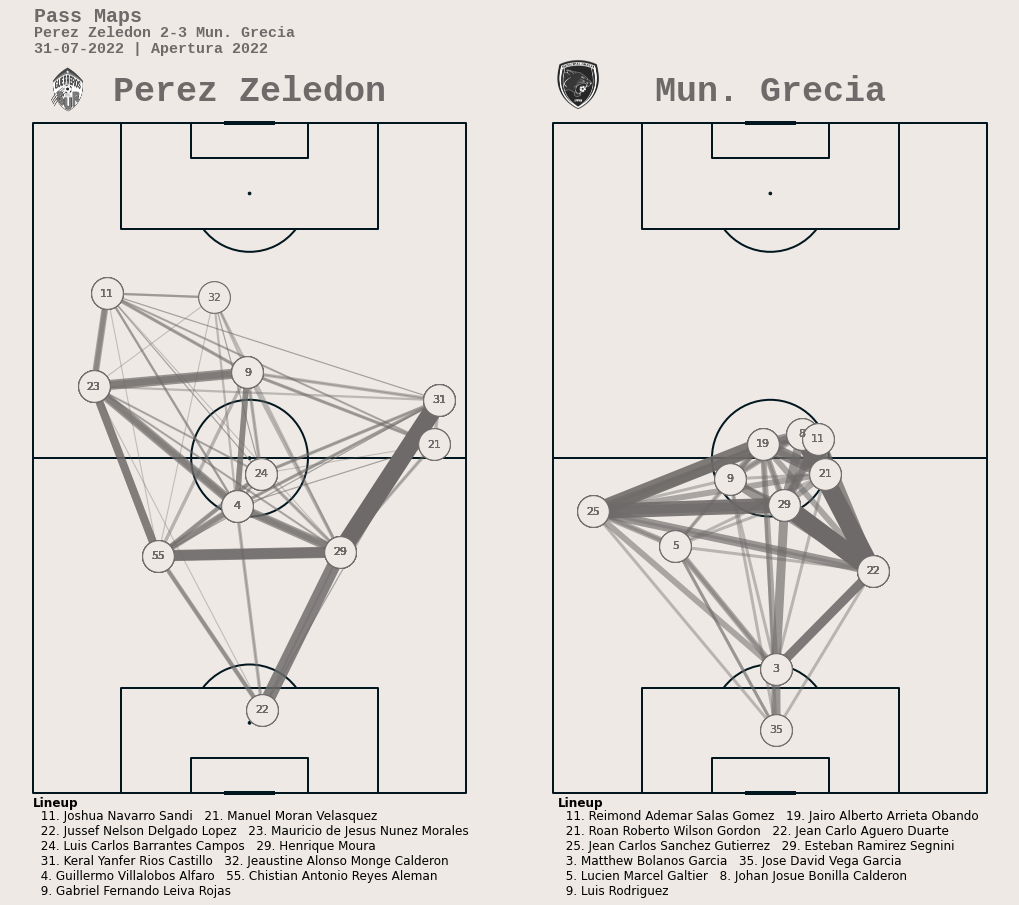

In [26]:
pass_maps('Perez-Zeledon-2-3-Municipal-Grecia','Perez Zeledon','Mun. Grecia')

In [27]:
fm.findSystemFonts(fontpaths=None, fontext="ttf")
#!rm ~/.cache/matplotlib -rf

['/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf',
 '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberat

## `Team heatmap`

### Function

In [28]:
def team_heatmap(data,game,team):
  from matplotlib.colors import LinearSegmentedColormap

  game = game
  team = team

  # Filter data for the specific game and team
  data_df = data.query("Partido == @game and Equipos == @team ")

  # Convert columns to numeric
  data_df['pos_x'] = pd.to_numeric(data_df['pos_x'])
  data_df['pos_y'] = pd.to_numeric(data_df['pos_y'])
  
  # Setup the rival team
  rival = data_df.query("rival != @team")
  rival = rival['rival'].unique()


  # Main
  pitch = VerticalPitch(pitch_type='custom',
                pitch_length=105,
                pitch_width=68,
                pitch_color='#eee9e5',
                line_zorder=2, 
                line_color='#01161E')
  fig, ax = pitch.draw(figsize=(8, 14))
  fig.set_facecolor("#eee9e5")

  pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#eee9e5', '#2f3e46'], N=100)
  
  kdeplot = pitch.kdeplot(data_df.pos_x, data_df.pos_y, ax=ax, cmap=pearl_earring_cmap, shade=True, levels=300)
  #ax.set_title(f'Jean Carlos Sanchez', fontsize=30, pad=-20)
  #subtitle = "{} \n vs {}".format(team,rival)
  #ax.set_title(subtitle, fontsize=30, pad=-20)

  _,image_team = set_logos(team,team)

  ax_logo = add_image(image_team, fig,
                        left=0.0480,
                        bottom=0.88,
                        height=0.05)
  ax.text(34, 110,team, 
              size=35,
              fontproperties = fontprop,
              #fontname = 'Oswald',
              fontweight = 'bold',
              ha='center', va='center', color='#6d6a69')


### Example

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


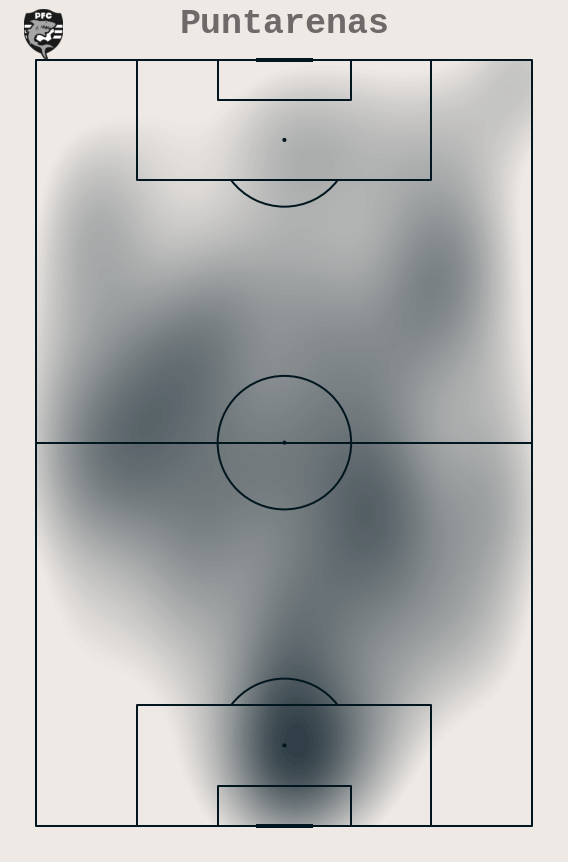

In [29]:
a = team_heatmap(main_df,game='Deportivo-Saprissa-1-1-Puntarenas2',team='Puntarenas')


## `Average Positions`

### Function

In [30]:
def players_pos(game):
  game = game

  main_df['pos_x'] = pd.to_numeric(main_df['pos_x'])
  main_df['pos_y'] = pd.to_numeric(main_df['pos_y'])


  #https://sql2pandas.pythonanywhere.com/cookbook/sql-avg-in-pandas
  data_pos = main_df.groupby(['Partido','Equipos','camisa','jugador']).agg(avg_pos_x=('pos_x', 'mean'), avg_pos_y=('pos_y', 'mean')).reset_index() 
  data_pos = data_pos.query("Partido == @game ")

  
  return data_pos


In [31]:
def average_positions(game,team1,team2):
  import re
  import warnings
  warnings.simplefilter("ignore", UserWarning)

  # Variables
  game = game
  team1 = team1
  team2 = team2

  # Get starting 11
  start11 = get_lineups(main_df)

  # Get average position for players in the game
  avg_position = players_pos(game)

  # Join starting 11 and avg positions to get the satring 11 players with the corresponding average position for the game
  avg_position = avg_position.join(start11.set_index(['Partido','Equipos','camisa','jugador']), on=['Partido','Equipos','camisa','jugador'],lsuffix="_avg",rsuffix='_str')
  avg_position = avg_position.query("Partido == @game")
  avg_position = avg_position.dropna()

  avg_position['full_name'] = avg_position.camisa + '.' + avg_position.jugador

    
  
  # Get game details for title
  game_details = main_df.query("Partido == @game")

  game_date = game_details['fecha_partido'].unique()
  home_team = game_details['equipo_casa'].unique()
  away_team = game_details['equipo_visita'].unique()
  final_result = game_details['marcador'].unique()
  tournament = game_details['nombre_torneo'].unique()

  # Clean variable strings
  game_date = str(game_date).replace('[', '').replace(']', '').replace("'",'')
  home_team = str(home_team).replace('[', '').replace(']', '').replace("'",'')
  away_team = str(away_team).replace('[', '').replace(']', '').replace("'",'')
  final_result = str(final_result).replace('[', '').replace(']', '').replace("'",'')
  tournament = str(tournament).replace('[', '').replace(']', '').replace("'",'')


  
  
  # Main graph
  pitch = VerticalPitch(pitch_type='custom',
                pitch_length=105,
                pitch_width=68,
                pitch_color='#eee9e5', 
                line_color='#01161E')
  fig, axs = pitch.grid(figheight=14 ,ncols=2, axis=False, endnote_height=0.05,title_height=0.08,)
  fig.set_facecolor("#eee9e5")
  for idx, ax in enumerate(axs['pitch'].flat):
    if idx == 0:
      ######### TEAM 1 PASS MAP #########
      ax1 = ax
      # Filter data for one game, and one team
      team1_posiciones = avg_position.query("Equipos == @team1 ")

      hull = pitch.convexhull(team1_posiciones.avg_pos_x, team1_posiciones.avg_pos_y)
      poly = pitch.polygon(hull, ax=ax1, edgecolor='#6d6a69', facecolor='#6d6a69', alpha=0.3)

      pass_nodes = pitch.scatter(team1_posiciones['avg_pos_x'], team1_posiciones['avg_pos_y'],
                              s=1000, color='#6d6a69', edgecolors='black', linewidth=1, alpha=1, ax=ax1)

      # Put player number in markers
      for index, row in team1_posiciones.iterrows():
        pitch.annotate(row.camisa, xy=(row.avg_pos_x, row.avg_pos_y), c='white', va='center',ha='center',fontweight = 'bold', size=11, ax=ax1)

      ######### TITLE SECTION #########
      #ss = pass_count_players.query("Partido == @game")
      
      #team1 = pass_count_players_test['Equipos'].unique()
      ax1.text(34, 110, team1, 
              size=35,
              fontproperties = fontprop,
              #fontname = 'Oswald',
              fontweight = 'bold',
              ha='center', va='center', color='#6d6a69')


      #################################

      # List of players
      
      players = team1_posiciones[['full_name','camisa']]
      players = players.dropna()
      players = players.sort_values(by=['camisa'],ascending=True)
      players = players['full_name'].unique()
      players_name = str(players)
      players_name = players_name.replace('[',' ')
      players_name = players_name.replace(']',' ')
      players_name = players_name.replace("'",' ')
      


      axs['endnote'].text(0, 0.5, players_name,
                      fontsize=12, va='center', ha='left', color='black')
      axs['endnote'].text(0, 1.5, 'Lineup',
                      fontsize=12, va='center', ha='left', color='black',fontweight = 'bold') 
    else:
      
      ######### TEAM 2 PASS MAP #########
      ax2 = ax

      # Filter data for one game, and one team
      team2_posiciones = avg_position.query("Equipos == @team2 ")

      team = team2

      hull = pitch.convexhull(team2_posiciones.avg_pos_x, team2_posiciones.avg_pos_y)
      poly = pitch.polygon(hull, ax=ax2, edgecolor='#6d6a69', facecolor='#6d6a69', alpha=0.3)

      pass_nodes2 = pitch.scatter(team2_posiciones['avg_pos_x'], team2_posiciones['avg_pos_y'],
                              s=1000, color='#6d6a69', edgecolors='black', linewidth=1, alpha=1, ax=ax2)
      # Put player number in markers
      for index, row in team2_posiciones.iterrows():
        pitch.annotate(row.camisa, xy=(row.avg_pos_x, row.avg_pos_y), c='white', va='center',ha='center',fontweight = 'bold', size=11, ax=ax2)

      ######### TITLE SECTION #########
      ax2.text(34, 110,team2, 
              size=35,
              fontproperties = fontprop,
              #fontname = 'Oswald',
              fontweight = 'bold',
              ha='center', va='center', color='#6d6a69')


      #################################


      # List of players      
      players = team2_posiciones[['full_name','camisa']]
      players = players.dropna()
      players = players.sort_values(by=['camisa'],ascending=True)
      players = players['full_name'].unique()
      players_name = str(players)
      players_name = players_name.replace('[',' ')
      players_name = players_name.replace(']',' ')
      players_name = players_name.replace("'",' ')

      axs['endnote'].text(0.55, 0.5, players_name,
                      fontsize=12, va='center', ha='left', color='black') 
      
      axs['endnote'].text(0.55, 1.5, 'Lineup',
                      fontsize=12, va='center', ha='left', color='black',fontweight = 'bold') 
      
      

  ######### TITLE SECTION #########
  axs['title'].text(0.001, 0.88, 'Average Position', fontsize=20,
                     va='center', ha='left',color='#6d6a69',fontweight = 'bold',fontproperties = game_det_fontprop)
  axs['title'].text(0.001, 0.68, f'{home_team} {final_result} {away_team}', fontsize=12, 
                     va='center', ha='left',color='#6d6a69',fontproperties= title_det_fontprop)
  axs['title'].text(0.001, 0.48, f'{game_date} | {tournament}', fontsize=12,
                     va='center', ha='left',color='#6d6a69',fontproperties= title_det_fontprop)
  #################################

  ######### LOGO SECTION #########
  image_home, image_away = set_logos(team1,team2)

  ax_home_logo = add_image(image_home, fig,
                        left=0.0491,
                        bottom=0.82,
                        height=0.06)

  ax_away_logo = add_image(image_away, fig, 
                                left=0.53,
                                bottom=0.82,
                                height=0.07)
  
  plt.show()

  ####################################

### Example

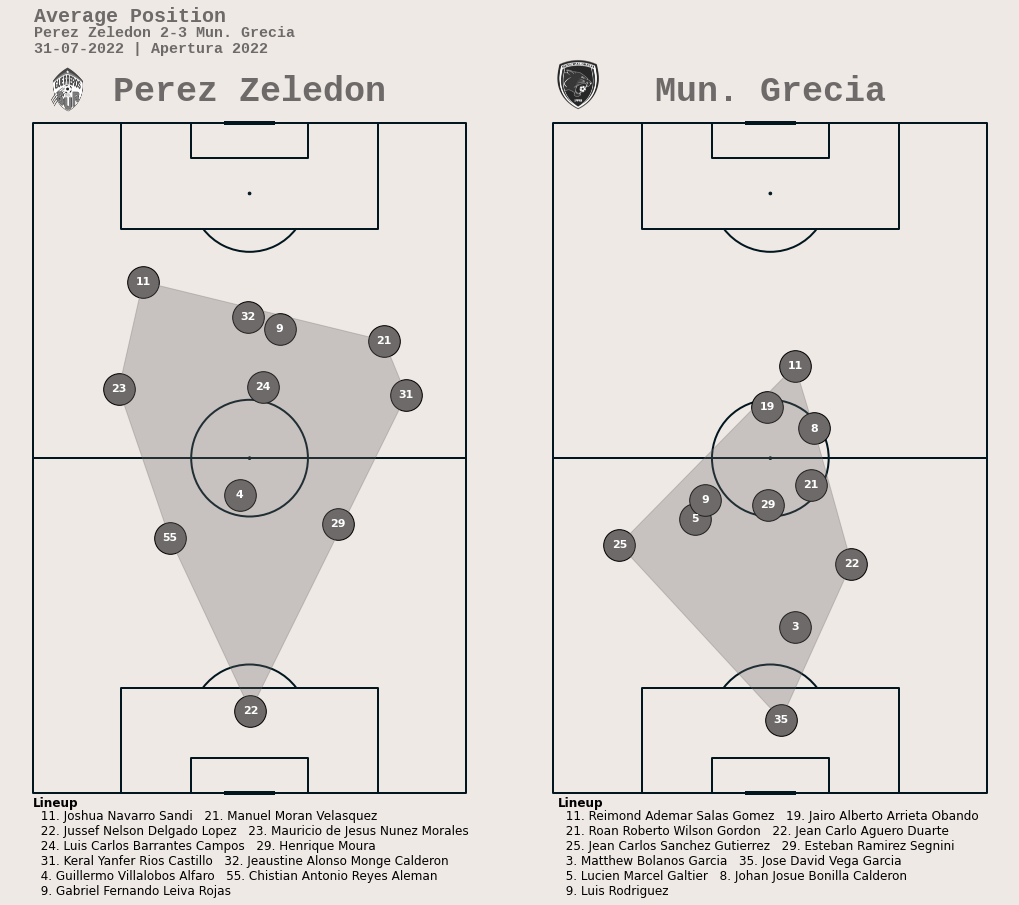

In [32]:
average_positions('Perez-Zeledon-2-3-Municipal-Grecia','Perez Zeledon','Mun. Grecia')

In [33]:
main_df.columns

Index(['ID', 'start', 'end', 'pos_x', 'pos_y', 'Partido', 'camisa', 'jugador',
       'Equipos', 'Acciones', 'Tiempo', 'fecha_partido', 'nombre_torneo',
       'equipo_casa', 'equipo_visita', 'marcador', 'goles_local',
       'goles_visita', 'rival', 'marcador_casa', 'marcador_visita',
       'detalle_marcador'],
      dtype='object')

In [ ]:
'''
cambios_df = main_df.query("Partido == 'Alajuelense-1-1-Sporting-FC2' and Equipos == 'Alajuelense' ")
cambios_df['ID'] = pd.to_numeric(cambios_df['ID'])
ultimas_acciones_jugadores = pysqldf("Select MAX([ID]) ultima_accion, jugador FROM cambios_df GROUP BY jugador ")
primeras_acciones_jugadores = pysqldf("Select MIN([ID]) primera_accion, jugador FROM cambios_df GROUP BY jugador ")
ultimas_acciones_jugadores

titulares = get_lineups(main_df)

titulares = titulares.query("Partido == 'Alajuelense-1-1-Sporting-FC2' and Equipos == 'Alajuelense'")
titulares

estado_titularidad = pysqldf("SELECT A.*, B.jugador as 'titular' FROM cambios_df A LEFT JOIN titulares B ON A.Partido = B.Partido and A.Equipos = B.Equipos and A.jugador = B.jugador")
estado_titularidad2 = pysqldf("SELECT DISTINCT jugador, titular FROM estado_titularidad")

pysqldf("SELECT A.*, B.*, C.* FROM estado_titularidad2 A LEFT JOIN ultimas_acciones_jugadores B ON A.jugador = B.jugador LEFT JOIN primeras_acciones_jugadores C ON A.jugador = C.jugador")
'''

## Testing

In [ ]:
main_df['Partido'].unique()

In [44]:
pass_flow_df.head()

,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones,pos_x_end,pos_y_end,jugador_end,camisa_end,equipos_end,acciones_end
0,2,4.050781,24.05,52.9,34.2,Guanacasteca-0-2-Herediano2,10,Yeltsin Tejeda,Herediano,Pases precisos,35.4,39.5,Ariel Roman Soto,5,Herediano,Pases precisos
1,5,7.320312,27.32,35.4,39.5,Guanacasteca-0-2-Herediano2,5,Ariel Roman Soto,Herediano,Pases precisos,61.9,19.0,Orlando Moises Galo Calderon,4,Herediano,Pases precisos
2,7,8.773438,28.77,61.9,19.0,Guanacasteca-0-2-Herediano2,4,Orlando Moises Galo Calderon,Herediano,Pases precisos,71.3,13.7,Anthony Daniel Contreras Enriquez,9,Herediano,Pases inefectivo
4,11,21.250000,41.25,61.0,0.0,Guanacasteca-0-2-Herediano2,97,Rawy Jafet Rodriguez Osorio,Herediano,Pases precisos,40.0,11.7,Juan Miguel Basulto Medina,24,Herediano,Pases precisos
5,14,25.187500,45.18,40.0,11.7,Guanacasteca-0-2-Herediano2,24,Juan Miguel Basulto Medina,Herediano,Pases precisos,33.9,33.2,Ariel Roman Soto,5,Herediano,Pases precisos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

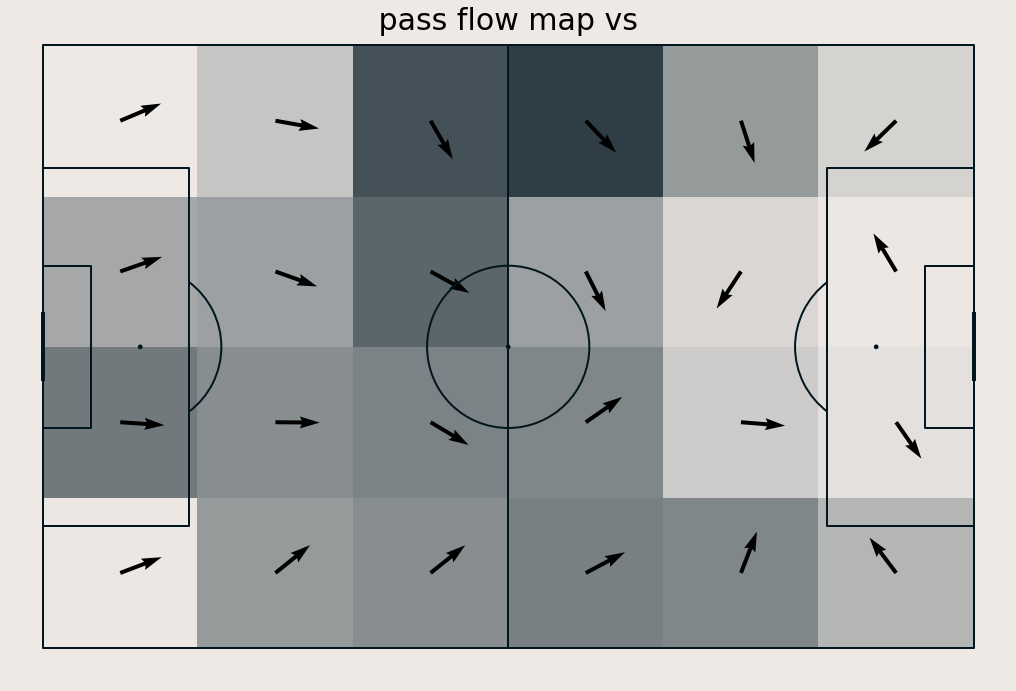

In [57]:
team_pass_flow_df = pass_flow_df.query("Equipos == 'Puntarenas' ")
team_pass_flow_df['pos_x'] = pd.to_numeric(team_pass_flow_df['pos_x'])
team_pass_flow_df['pos_x_end'] = pd.to_numeric(team_pass_flow_df['pos_x_end'])
team_pass_flow_df['pos_y'] = pd.to_numeric(team_pass_flow_df['pos_y'])
team_pass_flow_df['pos_y_end'] = pd.to_numeric(team_pass_flow_df['pos_y_end'])

pitch = Pitch(pitch_type='custom',
              axis=False,
              pitch_length=105,
              pitch_width=68,
              line_zorder=2,
              pitch_color='#eee9e5',
              line_color='#01161E')
bins = (6, 4)
team1 = ''
team2 = ''
fig, ax = pitch.draw(figsize=(14, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#eee9e5')

# plot the heatmap - darker colors = more passes originating from that square
bs_heatmap = pitch.bin_statistic(team_pass_flow_df.pos_x, 
                                 team_pass_flow_df.pos_y, 
                                 statistic='count', 
                                 bins=bins)
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#eee9e5', '#2f3e46'], N=100)
hm = pitch.heatmap(bs_heatmap, ax=ax, cmap=pearl_earring_cmap)

# plot the pass flow map with a single color ('black') and length of the arrow (5)
fm = pitch.flow(team_pass_flow_df.pos_x, team_pass_flow_df.pos_y, team_pass_flow_df.pos_x_end, team_pass_flow_df.pos_y_end,
                color='black', arrow_type='same',
                arrow_length=5, bins=bins, ax=ax)
ax_title = ax.set_title(f'{team1} pass flow map vs {team2}', fontsize=30, pad=-20)

## `Mapa de recuperaciones`

### Funcion

In [36]:
recuperaciones_df = pd.DataFrame()
perdidas_df = pd.DataFrame()
equipos = main_df['Equipos'].unique()
partidos = main_df['Partido'].unique()
for equipo in equipos:
  temp_df = main_df.query("Equipos == @equipo")
  temp_perdidas_df = temp_df.query("Acciones == 'Perdidas' ")
  perdidas_df = perdidas_df.append(temp_perdidas_df)
  temp_df = main_df.query("Equipos != @equipo")
  temp_recuperaciones_df = temp_df.query("Acciones == 'Perdidas' and rival == @equipo ")
  recuperaciones_df = recuperaciones_df.append(temp_recuperaciones_df)
  #print(len(temp_df),len(perdidas_df),len(recuperaciones_df), equipo)

In [37]:
def recuperaciones_chart(data,team):
  team = team
  data_df = data.query("rival == @team")
  pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#eee9e5', '#2f3e46'], N=100)

  path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()]



  pitch = VerticalPitch(pitch_type='custom',
                        axis=False,
                        pitch_length=105,
                        pitch_width=68, 
                        line_zorder=2, 
                        pitch_color='#eee9e5',
                        line_color='#01161E')
  fig, axs = pitch.grid(endnote_height=0.03, 
                        endnote_space=0,
                        title_height=0.08, 
                        title_space=0,
                        figheight=14,
                        # Turn off the endnote/title axis. I usually do this after
                        # I am happy with the chart layout and text placement
                        axis=False,
                        grid_height=0.84)
  fig.set_facecolor('#eee9e5')

  # heatmap and labels
  bin_statistic = pitch.bin_statistic_positional(data_df.pos_x, 
                                                 data_df.pos_y, statistic='count',
                                                 positional='full', normalize=True)
  pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                          cmap=pearl_earring_cmap, edgecolors='#22312b')
  labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                              ax=axs['pitch'], ha='center', va='center',
                              str_format='{:.0%}',fontweight = 'bold',path_effects=path_eff)

  # endnote and title
  axs['endnote'].text(1, 0.5, 'xxx', va='center', ha='right', fontsize=15,
                      color='#dee6ea')
  axs['title'].text(0.5, 0.5, "Zonas de Recuperación de balón \n {}".format(team), color='#6d6a69',
                    va='center', ha='center',fontproperties = fontprop ,fontweight = 'bold',fontsize=25)



  # sphinx_gallery_thumbnail_path = 'gallery/pitch_plots/images/sphx_glr_plot_heatmap_positional_002.png'

  axs["pitch"].invert_yaxis()

  pitch.arrows(105, -2,
              95, -2, width=2, headwidth=10,
              headlength=10, color='red', ax=axs['pitch'])


### Example

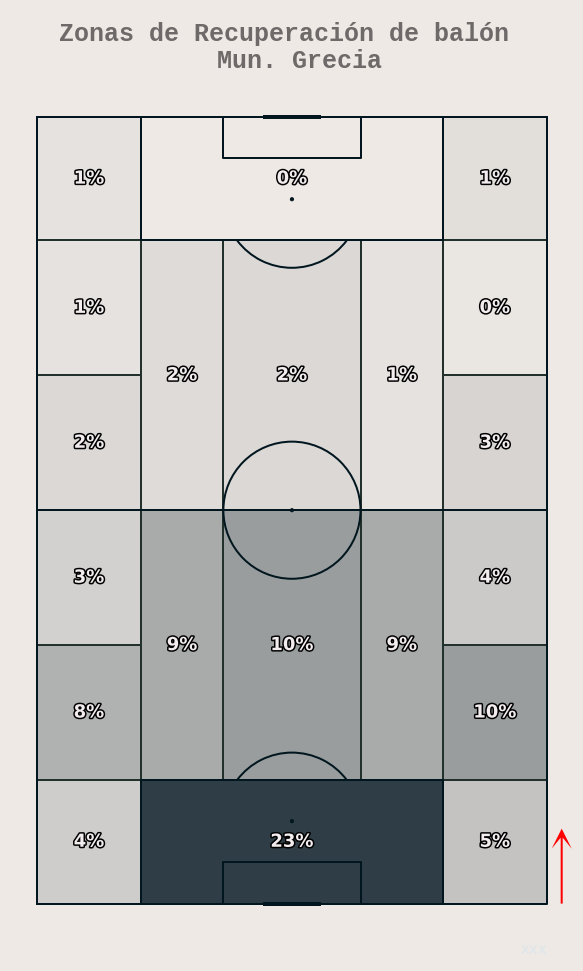

In [38]:
recuperaciones_chart(recuperaciones_df,"Mun. Grecia")

## `Mapa de perdidas`

### Funcion

In [39]:
def perdidas_chart(data,team):
  team = team
  data_df = data.query("Equipos == @team")

  pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                        ['#eee9e5', '#2f3e46'], N=100)

  path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
              path_effects.Normal()]


  pitch = VerticalPitch(pitch_type='custom',
                        axis=False,
                        pitch_length=105,
                        pitch_width=68, 
                        line_zorder=2, 
                        pitch_color='#eee9e5',
                        line_color='#01161E')


  fig, axs = pitch.grid(endnote_height=0.03, 
                        endnote_space=0,
                        title_height=0.08, 
                        title_space=0,
                        figheight=14,
                        # Turn off the endnote/title axis. I usually do this after
                        # I am happy with the chart layout and text placement
                        axis=False,
                        grid_height=0.84)
  fig.set_facecolor('#eee9e5')

  # heatmap and labels
  bin_statistic = pitch.bin_statistic_positional(data_df.pos_x, data_df.pos_y, statistic='count',
                                                positional='full', normalize=True)
  pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                          cmap=pearl_earring_cmap, edgecolors='#22312b')
  labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                              ax=axs['pitch'], ha='center', va='center',
                              str_format='{:.0%}', path_effects=path_eff,fontweight = 'bold')

  # endnote and title
  axs['endnote'].text(1, 0.5, '', va='center', ha='right', fontsize=15,
                      color='#dee6ea')
  axs['title'].text(0.5, 0.5, "Zonas de Pérdida de balón \n {}".format(team), color='#6d6a69',
                      va='center', ha='center',fontproperties = fontprop ,fontweight = 'bold',fontsize=25)

  pitch.arrows(5, -2,
              15, -2, width=2, headwidth=10,
              headlength=10, color='red', ax=axs['pitch'])



### Example

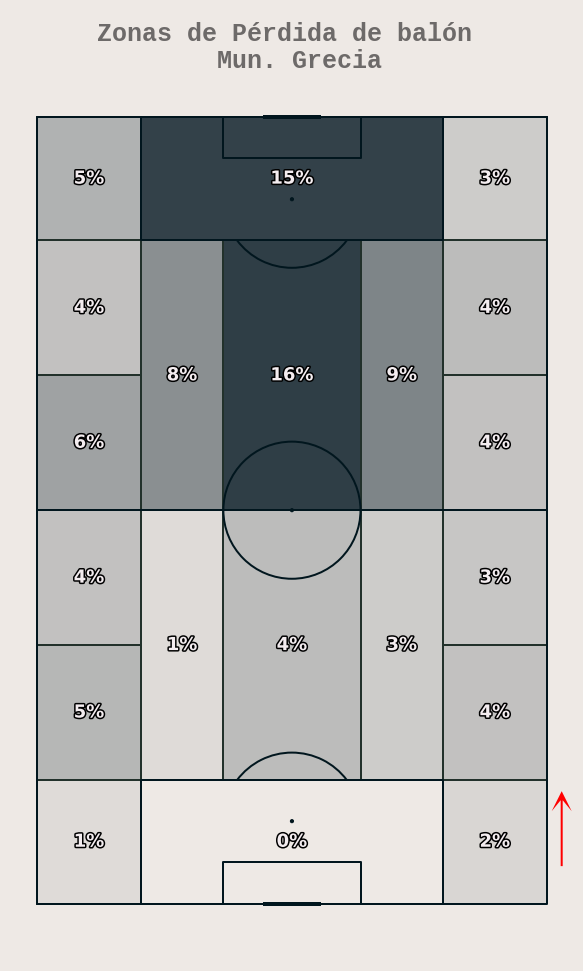

In [40]:
perdidas_chart(perdidas_df,'Mun. Grecia')

In [41]:
recuperaciones_df

,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones,...,nombre_torneo,equipo_casa,equipo_visita,marcador,goles_local,goles_visita,rival,marcador_casa,marcador_visita,detalle_marcador
82,84,138.375,158.32,54.7,52.7,Guanacasteca-0-2-Herediano2,18,Joseph Bolanos Valverde,Guanacasteca,Perdidas,...,Apertura 2022,Guanacasteca,Herediano,0-2,0,2,Herediano,0.0,0.0,0-0
169,171,225.750,245.76,95.6,41.3,Guanacasteca-0-2-Herediano2,22,Jedwin Lester,Guanacasteca,Perdidas,...,Apertura 2022,Guanacasteca,Herediano,0-2,0,2,Herediano,0.0,0.0,0-0
175,177,253.750,273.79,71.5,68.0,Guanacasteca-0-2-Herediano2,8,Dayron Miguel Sanchez Briceno,Guanacasteca,Perdidas,...,Apertura 2022,Guanacasteca,Herediano,0-2,0,2,Herediano,0.0,0.0,0-0
275,277,379.500,399.55,99.1,50.6,Guanacasteca-0-2-Herediano2,8,Dayron Miguel Sanchez Briceno,Guanacasteca,Perdidas,...,Apertura 2022,Guanacasteca,Herediano,0-2,0,2,Herediano,0.0,0.0,0-0
354,356,476.500,496.42,6.8,8.4,Guanacasteca-0-2-Herediano2,5,Yeison Molina Ruiz,Guanacasteca,Perdidas,...,Apertura 2022,Guanacasteca,Herediano,0-2,0,2,Herediano,0.0,0.0,0-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64865,2846,5372.000,5390.62,90.7,25.6,Guanacasteca-0-0-Sporting-FC-San-Jose2,9,Sergio Elias Bareiro Cardozo,Guanacasteca,Perdidas,...,Apertura 2022,Guanacasteca,Sporting FC,0-0,0,0,Sporting FC,0.0,0.0,0-0
64920,2901,5472.000,5490.28,93.8,41.6,Guanacasteca-0-0-Sporting-FC-San-Jose2,2,Haxzel Quiros,Guanacasteca,Perdidas,...,Apertura 2022,Guanacasteca,Sporting FC,0-0,0,0,Sporting FC,0.0,0.0,0-0
64997,2978,5536.000,5556.61,85.0,26.6,Guanacasteca-0-0-Sporting-FC-San-Jose2,16,Ariel Isaac Arauz Artola,Guanacasteca,Perdidas,...,Apertura 2022,Guanacasteca,Sporting FC,0-0,0,0,Sporting FC,0.0,0.0,0-0
65039,3020,5576.000,5597.54,52.0,0.0,Guanacasteca-0-0-Sporting-FC-San-Jose2,2,Haxzel Quiros,Guanacasteca,Perdidas,...,Apertura 2022,Guanacasteca,Sporting FC,0-0,0,0,Sporting FC,0.0,0.0,0-0
